In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
import wfdb
import random

### Load Data

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = "/Users/danielkim/Documents/MIDS/W207-ML/Final/Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100

Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: x[0] if len(x) > 0 else 'NORM')

# One Hot Encoding Meta Data

In [4]:
df = Y[['age', 'sex', 'height', 'weight', 'device']]

In [5]:
df = df.reset_index(drop=True, inplace=False)

In [6]:
meta = df.to_numpy()

In [7]:
enc = OneHotEncoder(handle_unknown='ignore')

In [8]:
enc.fit(meta)

OneHotEncoder(handle_unknown='ignore')

In [9]:
enc.categories_

[array([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0,
        14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0,
        25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0,
        36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0,
        47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0,
        58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0,
        69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0,
        80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 300.0],
       dtype=object),
 array([0, 1], dtype=object),
 array([6.0, 66.0, 67.0, 80.0, 85.0, 90.0, 93.0, 95.0, 97.0, 100.0, 104.0,
        109.0, 116.0, 120.0, 135.0, 136.0, 137.0, 139.0, 140.0, 142.0,
        143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0,
        152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0,
        161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.

In [10]:
meta_enc = enc.transform(meta).toarray()

In [11]:
meta_enc_pad = tf.keras.utils.pad_sequences(
    meta_enc,
    maxlen=1000,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)

In [12]:
meta_enc_reshaped = meta_enc_pad[..., np.newaxis]

In [13]:
X = meta_enc_final = np.concatenate((X, meta_enc_reshaped), axis=2)

In [14]:
X[0] # First example

array([[-0.119, -0.055,  0.064, ..., -0.039, -0.079,  0.   ],
       [-0.116, -0.051,  0.065, ..., -0.034, -0.074,  0.   ],
       [-0.12 , -0.044,  0.076, ..., -0.029, -0.069,  0.   ],
       ...,
       [ 0.069,  0.   , -0.069, ..., -0.041, -0.058,  0.   ],
       [ 0.086,  0.004, -0.081, ..., -0.046, -0.098,  0.   ],
       [ 0.022, -0.031, -0.054, ..., -0.035, -0.12 ,  0.   ]])

In [15]:
y = Y['diagnostic_superclass'].to_numpy()
classes, counts = np.unique(y, return_counts=True)
classes, counts # Don't end up with same counts each time - fix?

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([3942, 2371, 3162, 9924, 2400]))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [17]:
y_train.shape

(17439,)

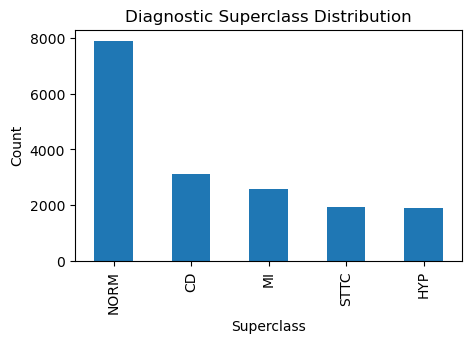

In [18]:
plt.figure(figsize=(5,3))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

In [19]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
print(train_classes, train_counts)

['CD' 'HYP' 'MI' 'NORM' 'STTC'] [3134 1906 2567 7907 1925]


### Correct Data Imbalance

In [20]:
smallest_class_count = min(train_counts)
print(smallest_class_count)

1906


In [21]:
def get_class_subset(ekg_class):
    y_train_class_indices = np.where(y_train == ekg_class)[0]
    y_train_class_subset_indices = np.random.choice(
        y_train_class_indices,
        size=smallest_class_count,
        replace=False
    )
    X_train_class_subset = X_train[y_train_class_subset_indices]
    y_train_class_subset = np.array([ekg_class] * smallest_class_count)
    return X_train_class_subset, y_train_class_subset

X_train_cd, y_train_cd = get_class_subset('CD')
X_train_hyp, y_train_hyp = get_class_subset('HYP')
X_train_mi, y_train_mi = get_class_subset('MI')
X_train_norm, y_train_norm = get_class_subset('NORM')
X_train_sttc, y_train_sttc = get_class_subset('STTC')

In [22]:
print(X_train_cd.shape)
#print(X_train_hyp.shape)
#print(X_train_mi.shape)
#print(X_train_norm.shape)
#print(X_train_sttc.shape)

(1906, 1000, 13)


In [23]:
X_train = np.concatenate((X_train_cd, X_train_hyp, X_train_mi, X_train_norm, X_train_sttc))
X_train.shape

(9530, 1000, 13)

In [24]:
#print(y_train_cd.shape)
#print(y_train_hyp.shape)
#print(y_train_mi.shape)
#print(y_train_norm.shape)
#print(y_train_sttc.shape)

In [25]:
y_train = np.concatenate((y_train_cd, y_train_hyp, y_train_mi, y_train_norm, y_train_sttc))
y_train.shape

(9530,)

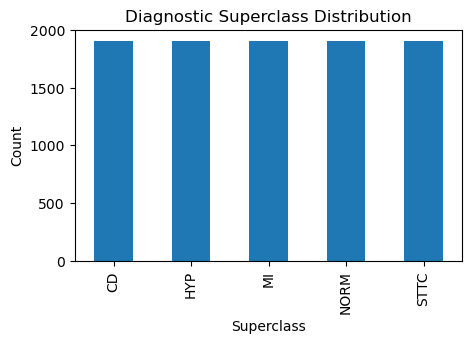

In [26]:
plt.figure(figsize=(5,3))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

### Split Data

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

In [28]:
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (7624, 1000, 13)
Training labels shape: (7624,) 

Validation data shape: (1906, 1000, 13)
Validation labels shape: (1906,) 

Test data shape: (4360, 1000, 13)
Test labels shape: (4360,)


### Normalize Data

In [29]:
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-16.32 9.39


In [30]:
def normalize(data):
    data_mean = data.mean()
    data_sd = data.std()
    return (data - data_mean) / data_sd

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [31]:
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-70.22010719813565 40.40483801213132


### Baseline Models

Training accuracy: 0.19530430220356768
Validation accuracy: 0.20199370409233997
Test accuracy: 0.1974770642201835


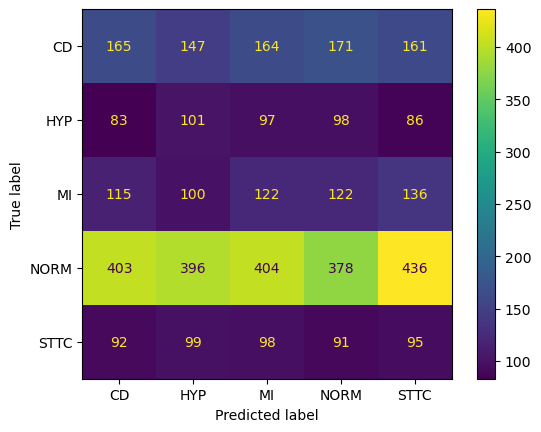

In [32]:
def random_classification(training_data):
    return [np.random.choice(classes) for _ in training_data]

predictions_train = random_classification(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = random_classification(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = random_classification(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

random_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=random_cm, display_labels=train_classes).plot();

Training accuracy: 0.20120671563483736
Validation accuracy: 0.19517313746065057
Test accuracy: 0.4626146788990826


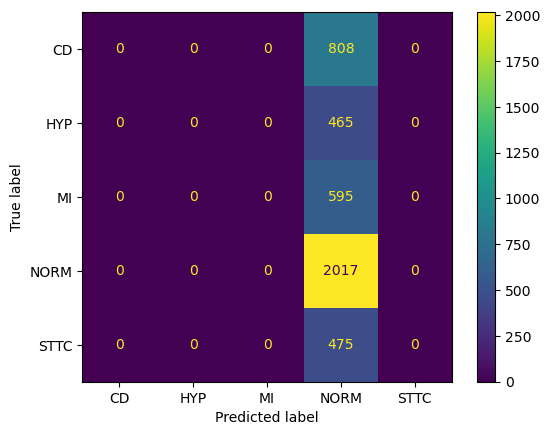

In [33]:
def always_classify_normal(training_data):
    return ['NORM'] * len(training_data)

predictions_train = always_classify_normal(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = always_classify_normal(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = always_classify_normal(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

normal_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=normal_cm, display_labels=train_classes).plot();

### Train Models

In [34]:
X_train_flattened = np.array([ekg.flatten() for ekg in X_train])
print(X_train_flattened.shape)

X_val_flattened = np.array([ekg.flatten() for ekg in X_val])
print(X_val_flattened.shape)

X_test_flattened = np.array([ekg.flatten() for ekg in X_test])
print(X_test_flattened.shape)

(7624, 13000)
(1906, 13000)
(4360, 13000)


**Neural Network**

In [35]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

In [45]:
model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(1000, 13)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)

model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
# model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
test_accuracy

Epoch 1/5
239/239 [==============================] - 8s 32ms/step - loss: nan - categorical_accuracy: 0.3641 - val_loss: nan - val_categorical_accuracy: 0.3919
Epoch 2/5
239/239 [==============================] - 8s 32ms/step - loss: nan - categorical_accuracy: 0.4020 - val_loss: nan - val_categorical_accuracy: 0.3919
Epoch 3/5
239/239 [==============================] - 8s 31ms/step - loss: nan - categorical_accuracy: 0.4020 - val_loss: nan - val_categorical_accuracy: 0.3919
Epoch 4/5
239/239 [==============================] - 8s 35ms/step - loss: nan - categorical_accuracy: 0.4020 - val_loss: nan - val_categorical_accuracy: 0.3919
Epoch 5/5
239/239 [==============================] - 8s 33ms/step - loss: nan - categorical_accuracy: 0.4020 - val_loss: nan - val_categorical_accuracy: 0.3919
137/137 - 1s - loss: nan - categorical_accuracy: 0.2943 - 1s/epoch - 9ms/step


0.2942660450935364

In [50]:
def build_model(num_conv_layers=3, 
                conv_filters=[64, 128, 256],
                conv_kernel_size=3,
                conv_activation='relu',
                pool_size=2,
                dense_units=[256, 128, 64, 32, 16],
                dense_activation='relu',
                dropout_rate=0.5,
                input_shape=(1000, 13),
                num_classes=12,
                optimizer='adam',
                loss='categorical_crossentropy',
                learning_rate = 0.01):
    
    model = models.Sequential()
    
    for i in range(num_conv_layers):
        model.add(layers.Conv1D(conv_filters[i], conv_kernel_size, activation=conv_activation, input_shape=input_shape))
        model.add(layers.MaxPooling1D(pool_size))
    
    model.add(layers.Flatten())
    
    for units in dense_units:
        model.add(layers.Dense(units, activation=dense_activation))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

Epoch 1/3
239/239 [==============================] - 3s 14ms/step - loss: 179.5631 - accuracy: 0.1970 - val_loss: 6588.6484 - val_accuracy: 0.0000e+00
Epoch 2/3
239/239 [==============================] - 3s 13ms/step - loss: 18372012032.0000 - accuracy: 0.1393 - val_loss: 69871714304.0000 - val_accuracy: 0.1952
Epoch 3/3
239/239 [==============================] - 3s 13ms/step - loss: 1726351933440.0000 - accuracy: 0.1266 - val_loss: 2817622278144.0000 - val_accuracy: 0.1952
Epoch 1/3
239/239 [==============================] - 4s 14ms/step - loss: 7362875904.0000 - accuracy: 0.0859 - val_loss: 66228355072.0000 - val_accuracy: 0.3919
Epoch 2/3
239/239 [==============================] - 3s 14ms/step - loss: 97739404738560.0000 - accuracy: 0.1240 - val_loss: 246015827378176.0000 - val_accuracy: 0.3919
Epoch 3/3
239/239 [==============================] - 3s 14ms/step - loss: 3930079222562816.0000 - accuracy: 0.1243 - val_loss: 6366140649439232.0000 - val_accuracy: 0.1952
Epoch 1/3
239/239 [

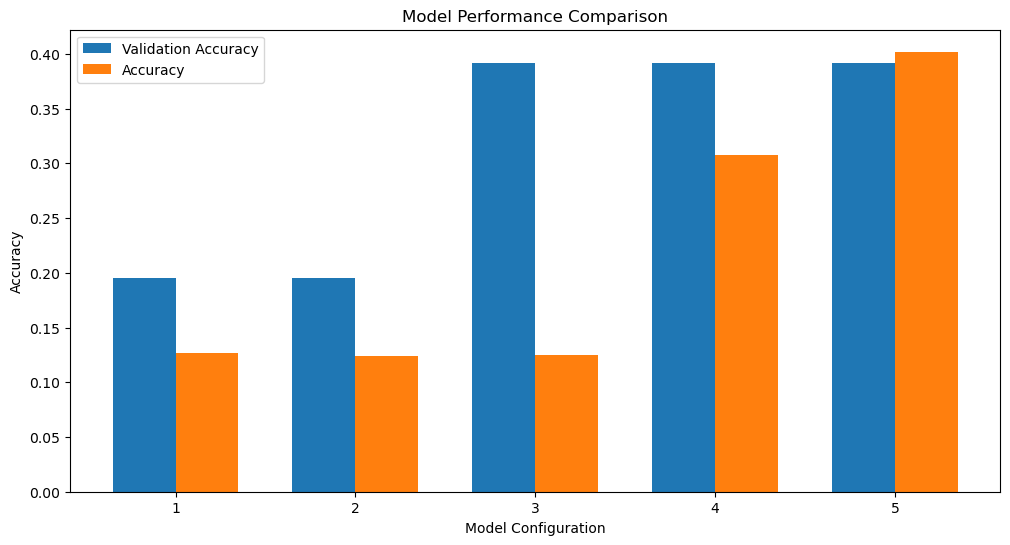

In [51]:
def test_model_configurations(X_train, y_train, X_val, y_val):
    
    results = {}
    
    #parameters to test out
    #[test_id, num_conv_layers, conv_filters, dense_units, dropout_rate, pool_size]
    parameters = np.array([
        [1, 1,[64],[256, 128, 64, 32, 16],0.5,2],
        [2, 2,[64, 64],[256, 128, 64, 32, 16],0.5,2],
        [3, 3,[64, 64, 64],[256, 128, 64, 32, 16],0.5,2],
        [4, 4,[64, 64, 64, 64],[256, 128, 64, 32, 16],0.5,2],
        [5, 5,[64, 64, 64, 64, 64],[256, 128, 64, 32, 16],0.5,2]
    ])
    
    for parameter in parameters:
        model = build_model(
            num_conv_layers = parameter[1], 
            conv_filters = parameter[2],
            dense_units = parameter[3],
            dropout_rate = parameter[4],
            pool_size = parameter[5]
        )
        history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))
        
        results[str(parameter[0])] = {
            'val_accuracy': history.history['val_accuracy'][-1],
            'accuracy': history.history['accuracy'][-1]
        }
    
    return results


results = test_model_configurations(X_train, y_train, X_val, y_val)

plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

plt.bar(x - width/2, [results[k]['val_accuracy'] for k in results], width, label='Validation Accuracy')
plt.bar(x + width/2, [results[k]['accuracy'] for k in results], width, label='Accuracy')

plt.xticks(x, results.keys())
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

In [ ]:
def test_model_configurations(X_train, y_train, X_val, y_val):
    
    results = {}
    
    #parameters to test out
    #[test_id, num_conv_layers, conv_filters, dense_units, dropout_rate, pool_size]
    parameters = np.array([
        [6, 3,[64, 128, 256],[256, 128, 64, 32, 16],0.5,2],
        [7, 3,[128, 128, 128],[256, 128, 64, 32, 16],0.5,2],
        [8, 3,[256, 256, 256],[256, 128, 64, 32, 16],0.5,2],
        [9, 3,[256, 128, 64],[256, 128, 64, 32, 16],0.5,2],
        [10, 3,[64, 64, 64],[256, 128, 64, 32, 16],0.5,2]
    ])
    
    for parameter in parameters:
        model = build_model(
            num_conv_layers = parameter[1], 
            conv_filters = parameter[2],
            dense_units = parameter[3],
            dropout_rate = parameter[4],
            pool_size = parameter[5]
        )
        history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
        
        results[str(parameter[0])] = {
            'val_accuracy': history.history['val_accuracy'][-1],
            'accuracy': history.history['accuracy'][-1]
        }
    
    return results


results = test_model_configurations(X_train, y_train, X_val, y_val)

plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

plt.bar(x - width/2, [results[k]['val_accuracy'] for k in results], width, label='Validation Accuracy')
plt.bar(x + width/2, [results[k]['accuracy'] for k in results], width, label='Accuracy')

plt.xticks(x, results.keys())
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()  

In [ ]:
def test_model_configurations(X_train, y_train, X_val, y_val):
    
    results = {}
    
    #parameters to test out
    #[test_id, num_conv_layers, conv_filters, dense_units, dropout_rate, pool_size]
    parameters = np.array([
        [6, 3,[64, 128, 256],[256, 128, 64, 32, 16],0.5,1],
        [7, 3,[128, 128, 128],[256, 128, 64, 32, 16],0.5,2],
        [8, 3,[256, 256, 256],[256, 128, 64, 32, 16],0.5,3]
    ])
    
    for parameter in parameters:
        model = build_model(
            num_conv_layers = parameter[1], 
            conv_filters = parameter[2],
            dense_units = parameter[3],
            dropout_rate = parameter[4],
            pool_size = parameter[5]
        )
        history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))
        
        results[str(parameter[0])] = {
            'val_accuracy': history.history['val_accuracy'][-1],
            'accuracy': history.history['accuracy'][-1]
        }
    
    return results


results = test_model_configurations(X_train, y_train, X_val, y_val)

plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

plt.bar(x - width/2, [results[k]['val_accuracy'] for k in results], width, label='Validation Accuracy')
plt.bar(x + width/2, [results[k]['accuracy'] for k in results], width, label='Accuracy')

plt.xticks(x, results.keys())
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()  

In [ ]:
training_accuracies = np.array(training_accuracies)
validation_accuracies = np.array(validation_accuracies)

In [ ]:
training_acc = training_accuracies[:, -1]
validation_acc = validation_accuracies[:, -1]

In [ ]:
accuracy = np.stack((training_acc, validation_acc), axis =1)
accuracy = pd.DataFrame(accuracy)

In [ ]:
plt.figure(figsize=(9, 5))
plt.scatter(training_acc, validation_acc)

plt.title('Training vs Validation Accuracy')
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Accross Epochs')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show();